## ARIMA/GARCH

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Загрузим нестационарный процесс с сезонностью

#### Модель airline passengers

In [291]:
data = pd.read_csv('data/international-airline-passengers.csv')
data.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


**Тест Дики-Фуллера**

In [3]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Результат теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Статистический тест', 'p-value', 'Lags', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Критические значения (%s)' % key] = value
    print(dfoutput)
    print('\n')
    if dftest[0]> dftest[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

**Отображение**

In [4]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(16, 14), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Результат теста Дики-Фуллера:
Статистический тест              0.815369
p-value                          0.991880
Lags                            13.000000
Number of Observations Used    130.000000
Критические значения (1%)       -3.481682
Критические значения (5%)       -2.884042
Критические значения (10%)      -2.578770
dtype: float64


есть единичные корни, ряд не стационарен


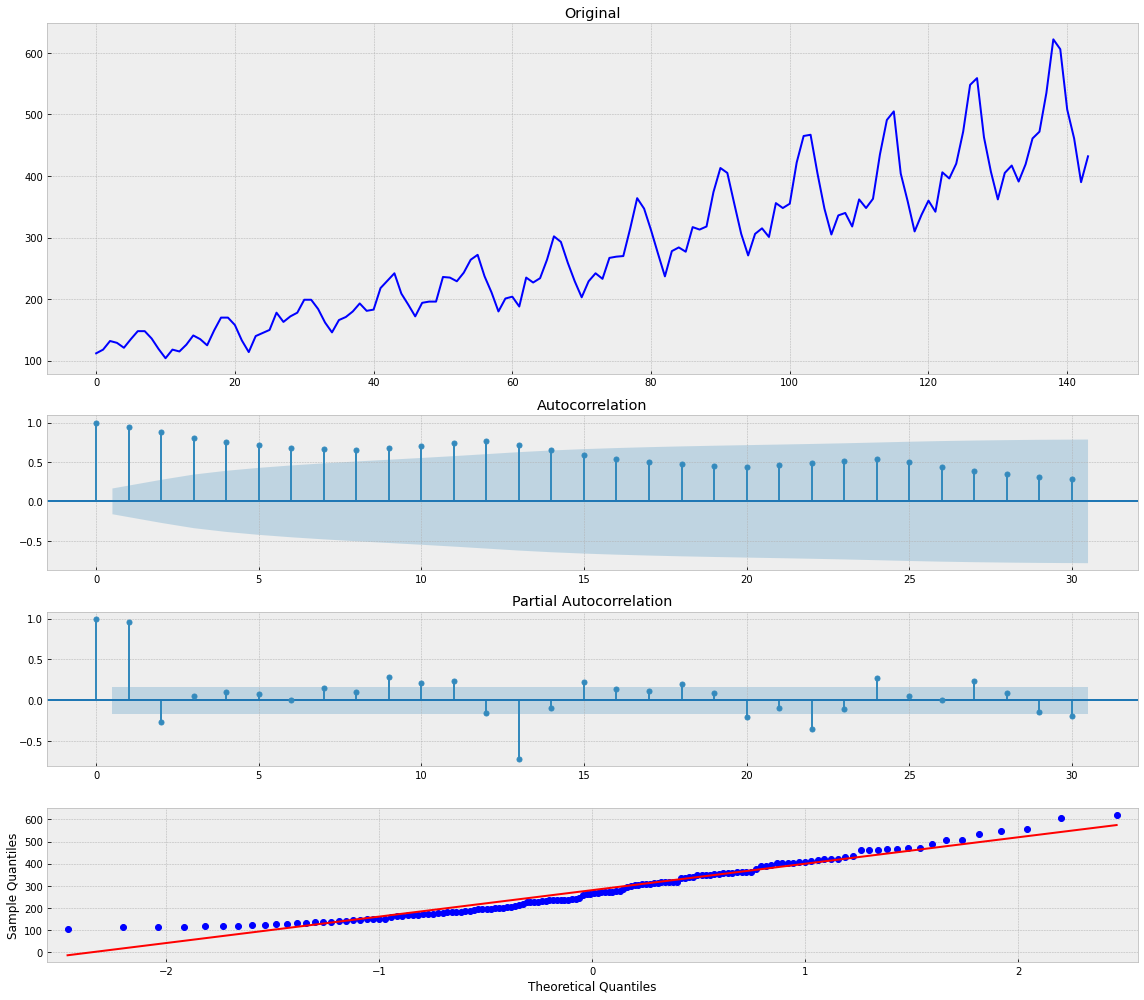

In [265]:
tsplot(data['Count'], lags=30)

Временной ряд $y_t$ (в нем есть тренд и сезонность)

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

## Превратим нестационарный процесс в стационарный

**Преобразование Бокса-Кокса (уберем изменение дисперсии - логарифмируя ряд)**

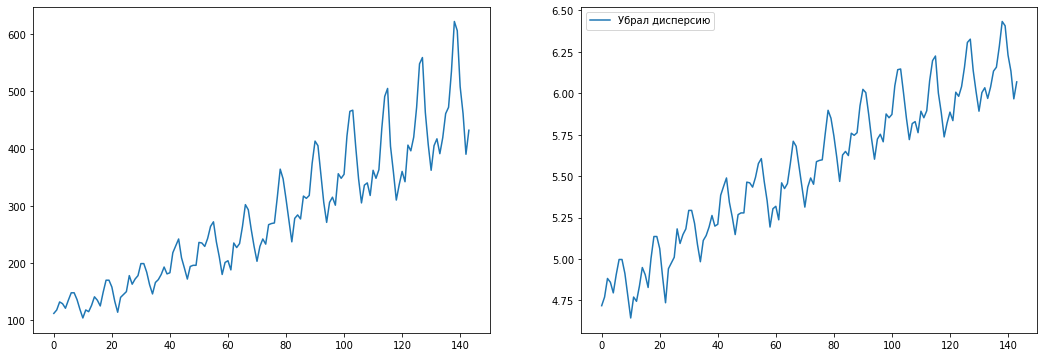

In [293]:
from scipy.stats import boxcox

#boxcox(data['Count']) - typle
#boxcox(data['Count'], 0) - array
series = boxcox(data['Count'], 0)

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(data['Count'])
ax2.plot(boxcox(data['Count'], 0), label="Убрал дисперсию")

plt.legend()

**Определим какой период сезонности (ориентируемся на график с большой корреляцией)**

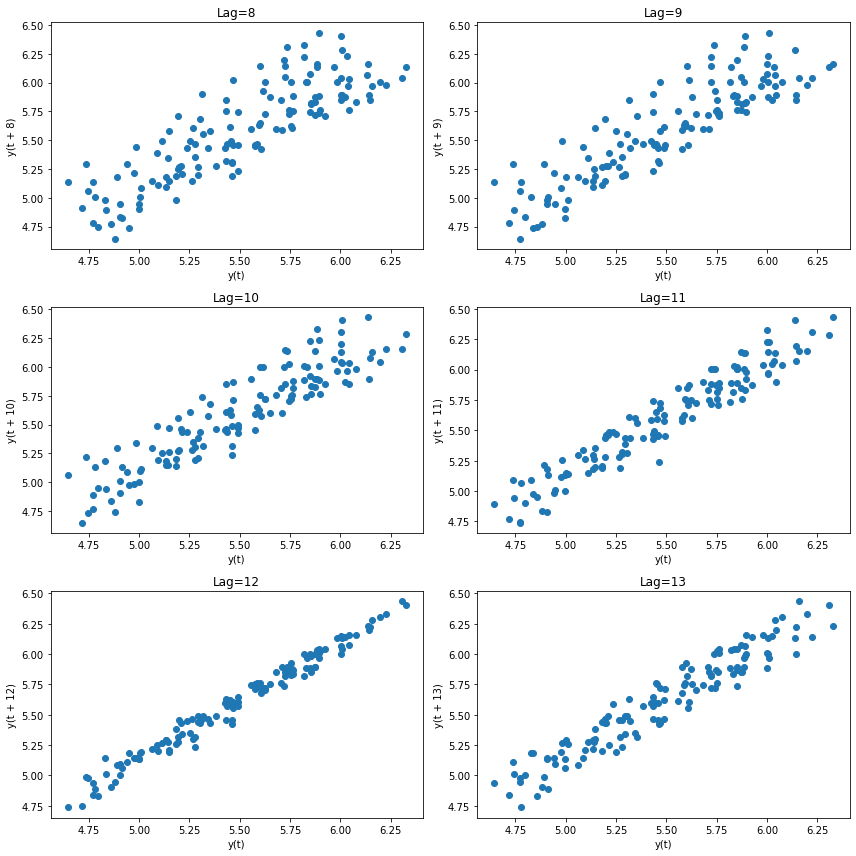

In [294]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 8):

    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    pd.plotting.lag_plot(pd.Series(series), lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.tight_layout()
plt.show()

Наибольшая корреляция у графика с лагом=12

In [44]:
#уберем наличие сильного тренда
#вычитаем временной ряд со второго значения до посленего (на 1 значение меньше)
series = series[1:]-series[:-1]

#уберем сильное влияние сезонности (каждые 12 месяцев)
#берем значения с 12ого значения и вычитаем 12 предыдущих значений (июнь след года вычитает июнь предыдущего, июль - июль и т.д)
series = series[12:]-series[:-12]

Результат теста Дики-Фуллера:
Статистический тест             -4.443325
p-value                          0.000249
Lags                            12.000000
Number of Observations Used    118.000000
Критические значения (1%)       -3.487022
Критические значения (5%)       -2.886363
Критические значения (10%)      -2.580009
dtype: float64


единичных корней нет, ряд стационарен


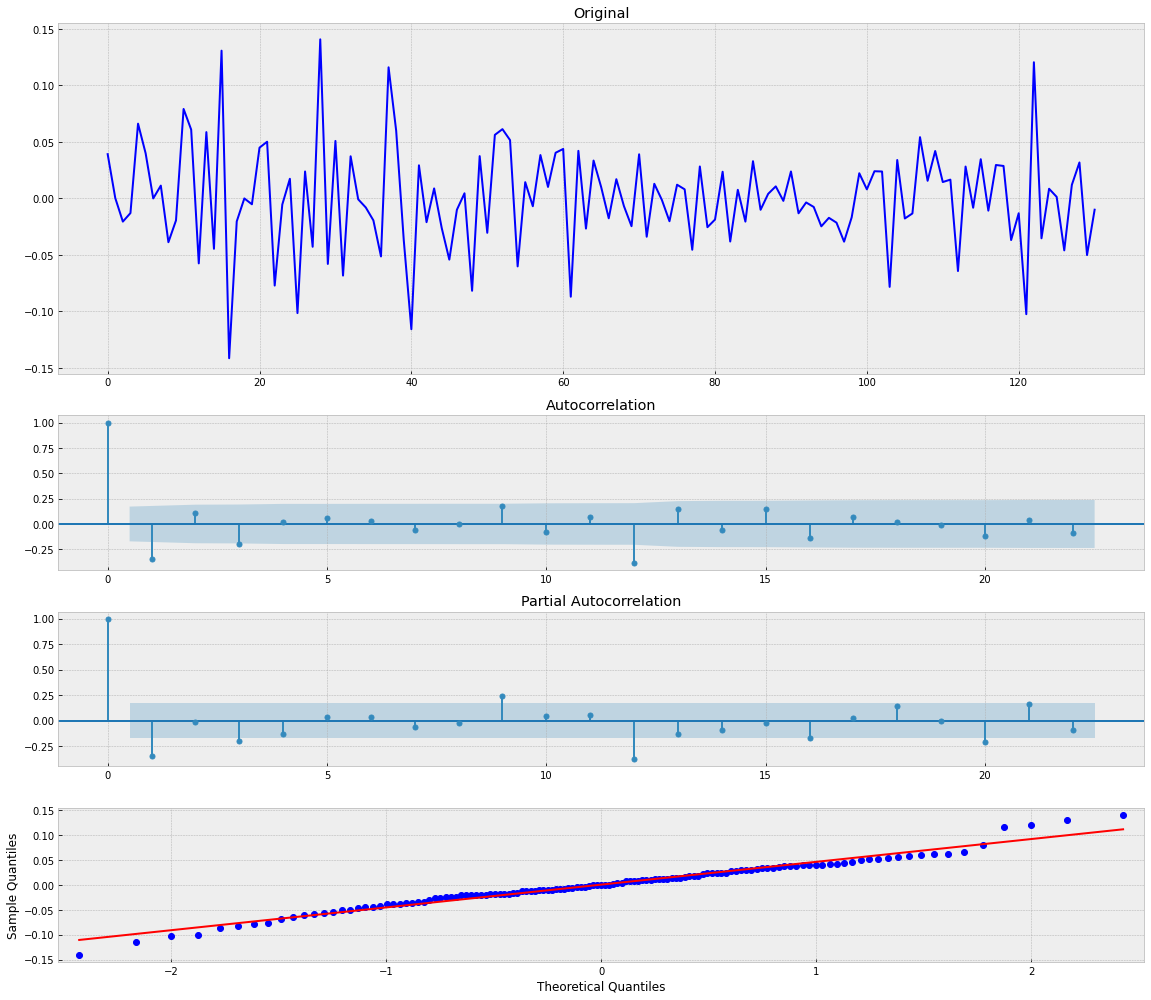

In [45]:
tsplot(series)

Получили стационарный ряд

### Подбор гиперпараметров модели

In [37]:
import warnings
warnings.filterwarnings('ignore')

def best_parametrs(d, series):
    if d == 0:
        print('Модель ARMA')
    else:
        print('Модель ARIMA')
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    max_lag = 30

    for i in range(5):
        for j in range(5):
            try:
            #tmp_mdl = smt.ARMA(series, order=(i, j)).fit(maxlag=max_lag, method='mle', trend='nc')
            #arma = arima (если в arima параметр d = 0)
            #d порядок дифференцирования (дифференцирует попарно, чтобы избавиться от тренда)
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(maxlag=max_lag, method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, d, j)))
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
    return best_aic, best_order

### Подбор гиперпараметров модели (с подбором порядка дифференцирования)

In [40]:
def best_parametrs_extended(ts):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(ts, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

## ARMA(p,q) - только для стационарных процессов

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

   1. AR-модели учитывают прошлое поведение (лаги) в качестве входных параметров. 
   2. MA-модели используются для оценки “информационных шоков” в серии. К примеру, такими шоками могут быть неожиданные события или поступление новой информации. То есть, MA-модель позволяет оценивать единовременную реакцию серии на шоки.
   3. ARMA-модели учитывают оба этих аспекта.
   4. ARMA-модели в принципе не учитывают эффекты “кластеризации волатильности”. Это не условные гетероскедастичные модели. Мы считаем, что дисперсия является постоянной в ARMA-моделях.

РАБОТАЕТ ТОЛЬКО НА СТАЦИОНАРНЫХ ВРЕМЕННЫХ РЯДАХ (допускается цикличность)

In [47]:
best_aic, best_order = best_parametrs(0, train_series)

Модель ARMA
aic: -263.67495 | order: (0, 0, 1)
aic: -261.85175 | order: (0, 0, 2)
aic: -263.27527 | order: (0, 0, 3)
aic: -261.82399 | order: (0, 0, 4)
aic: -262.67765 | order: (1, 0, 0)
aic: -262.05038 | order: (1, 0, 1)
aic: -261.36006 | order: (1, 0, 3)
aic: -260.70865 | order: (2, 0, 0)
aic: -263.79702 | order: (2, 0, 1)
aic: -262.85789 | order: (2, 0, 2)
aic: -267.88044 | order: (2, 0, 3)
aic: -263.27586 | order: (3, 0, 0)
aic: -261.92115 | order: (3, 0, 1)
aic: -267.48749 | order: (3, 0, 2)
aic: -266.62346 | order: (3, 0, 3)
aic: -260.72479 | order: (3, 0, 4)
aic: -262.23265 | order: (4, 0, 0)
aic: -260.29150 | order: (4, 0, 1)
aic: -266.17469 | order: (4, 0, 2)
aic: -264.93248 | order: (4, 0, 3)
aic: -259.08112 | order: (4, 0, 4)


Чем меньше критерий aic, тем выше качество модели

In [49]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -267.88044 | order: (2, 0, 3)


**Модель ARMA**

Результат теста Дики-Фуллера:
Статистический тест             -5.122297
p-value                          0.000013
Lags                            11.000000
Number of Observations Used    119.000000
Критические значения (1%)       -3.486535
Критические значения (5%)       -2.886151
Критические значения (10%)      -2.579896
dtype: float64


единичных корней нет, ряд стационарен


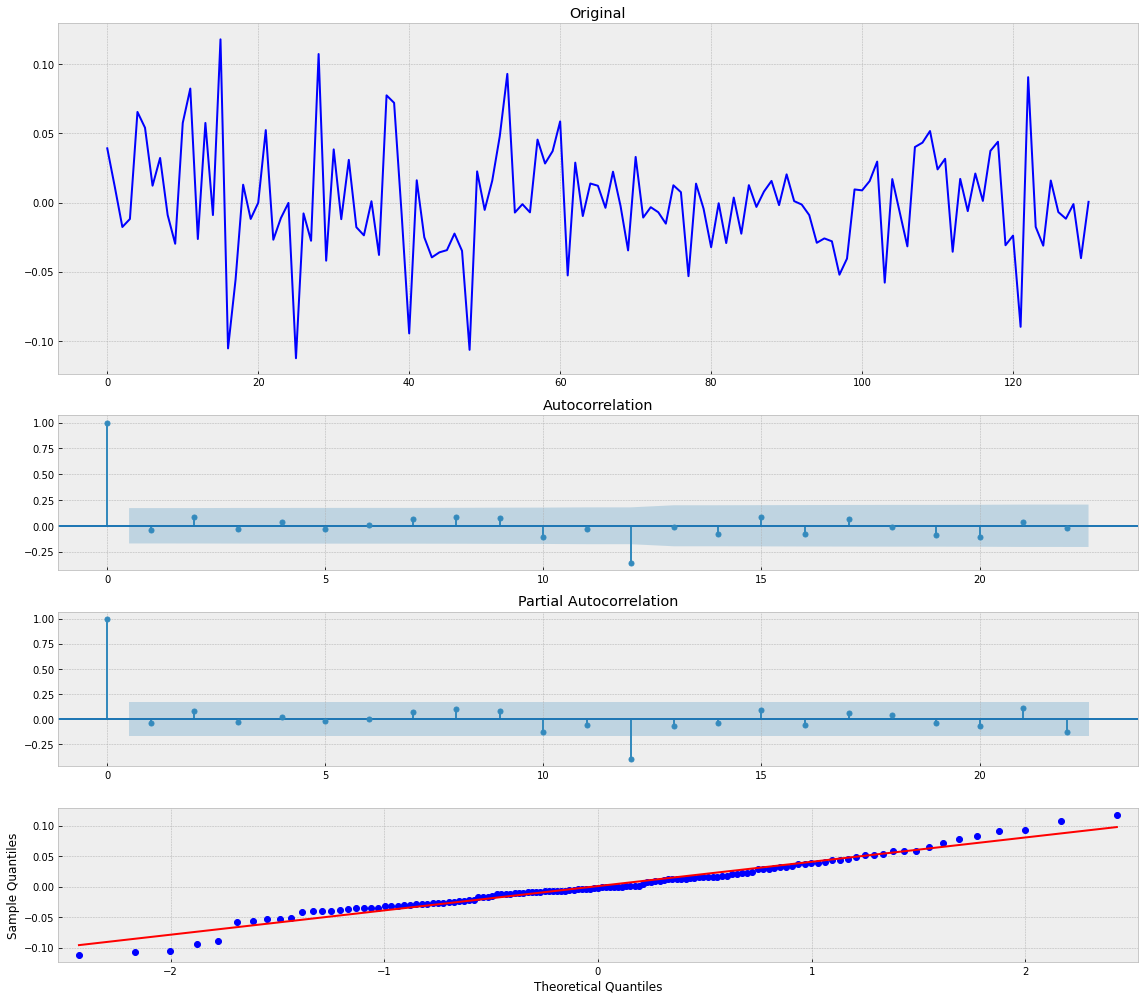

In [118]:
#mdl_1 = smt.ARMA(series, order=(2,3)).fit(method='mle', trend='nc') - тоже самое

mdl_1 = smt.ARIMA(series, order=(2,0,3)).fit(
                method='mle', trend='nc'
            )
tsplot(mdl_1.resid)

In [53]:
print(mdl_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   82
Model:                     ARMA(2, 3)   Log Likelihood                 139.940
Method:                           mle   S.D. of innovations              0.043
Date:                Tue, 06 Oct 2020   AIC                           -267.880
Time:                        12:58:49   BIC                           -253.440
Sample:                             0   HQIC                          -262.083
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.2570      0.077      3.324      0.001       0.105       0.409
ar.L2.y       -0.8424      0.076    -11.035      0.000      -0.992      -0.693
ma.L1.y       -0.6037      0.106     -5.705      0.0

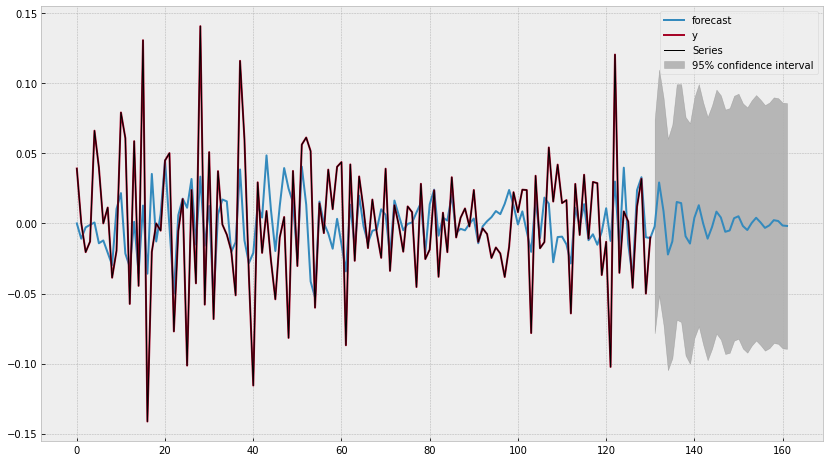

In [81]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl_1.plot_predict(0, len(series)+30, ax=ax)
    plt.plot(series, linewidth='1', color='black', label='Series')
    plt.legend()
    plt.show()

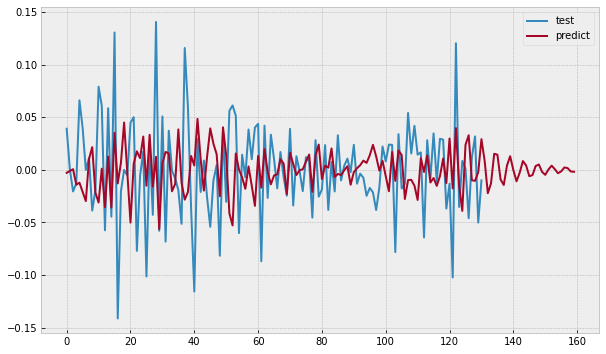

In [121]:
predict = mdl_1.predict(start=2, end=len(series)+30)

with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series, label="test")
    plt.plot(predict, label="predict")
    
    plt.legend()  

## ARIMA (p,d,q) - подходит для нестационарных процессов (не учитывается сезонность)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

In [87]:
best_aic, best_order = best_parametrs(1, series)

Модель ARIMA
aic: -423.62929 | order: (0, 1, 1)
aic: -437.70342 | order: (0, 1, 2)
aic: -435.74910 | order: (0, 1, 3)
aic: -438.33738 | order: (0, 1, 4)
aic: -376.68597 | order: (1, 1, 0)
aic: -437.11133 | order: (1, 1, 1)
aic: -436.55716 | order: (1, 1, 4)
aic: -386.01076 | order: (2, 1, 0)
aic: -448.99373 | order: (2, 1, 4)
aic: -395.60367 | order: (3, 1, 0)
aic: -437.62586 | order: (3, 1, 1)
aic: -436.32730 | order: (3, 1, 4)
aic: -410.26605 | order: (4, 1, 0)
aic: -437.41876 | order: (4, 1, 1)
aic: -441.86187 | order: (4, 1, 2)
aic: -440.09595 | order: (4, 1, 3)
aic: -450.87329 | order: (4, 1, 4)


In [88]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -450.87329 | order: (4, 1, 4)


In [106]:
mdl_2 = smt.ARIMA(series, order=(4,1,4)).fit(update_freq=5)
print(mdl_2.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  130
Model:                 ARIMA(4, 1, 4)   Log Likelihood                 234.611
Method:                       css-mle   S.D. of innovations              0.038
Date:                Tue, 06 Oct 2020   AIC                           -449.222
Time:                        13:19:01   BIC                           -420.547
Sample:                             1   HQIC                          -437.570
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.068e-05   6.88e-05     -0.591      0.555      -0.000    9.43e-05
ar.L1.D.y     -1.1938      0.078    -15.329      0.000      -1.346      -1.041
ar.L2.D.y     -1.0374      0.079    -13.084      0.0

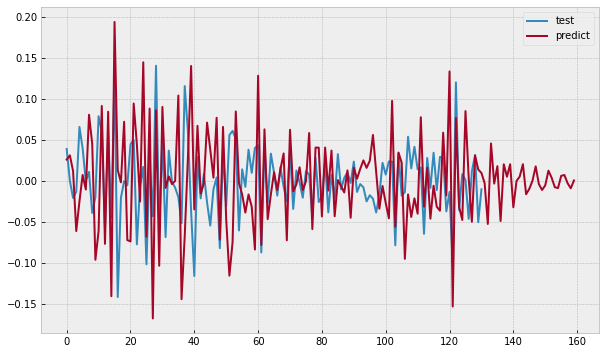

In [115]:
predict = mdl_2.predict(start=2, end=len(series)+30)

with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series, label="test")
    plt.plot(predict, label="predict")
    
    plt.legend()
   

Для данного анализа лучше подойдет SARIMA (учитывает сезонность) и SARIMAX (учитывает сезонность и тренд)

## SARIMAX - подходит для нестационарных процессов (учитывает сезонность и тренд)

In [96]:
mdl_3 = sm.tsa.SARIMAX(data['Count'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

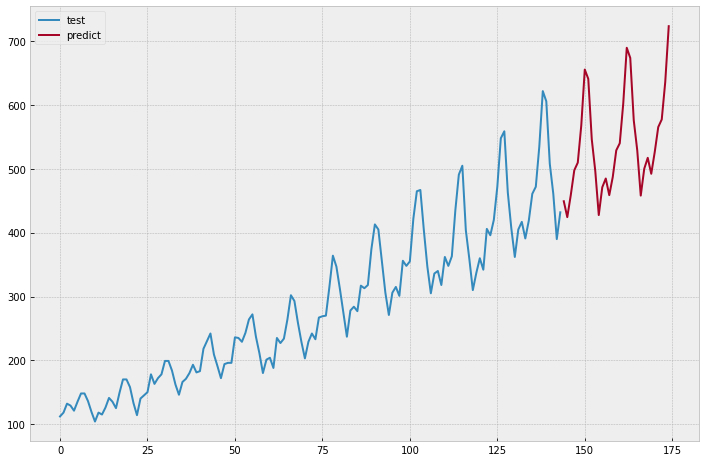

In [101]:
predict = mdl_3.predict(start=len(data['Count']), end=len(data['Count'])+30)

with plt.style.context('bmh'):
    plt.figure(figsize=(12, 8))
    plt.plot(data['Count'], label="test")
    plt.plot(predict, label="predict")
    
    plt.legend()

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [230]:
data = pd.read_csv('data/international-airline-passengers.csv')
series=data['Count']
series = boxcox(series, 0)

series = series[1:]-series[:-1]
series = series[12:]-series[:-12]

train_series, test_series = series[0:len(series)-48], series[len(series)-48:]

In [233]:
aic, order, mdl = _get_best_model(train_series)

aic: -271.17521 | order: (3, 0, 2)


In [234]:
p_, o_, q_ = order

In [235]:
#Строим модель ARIMA
mdl_4 = smt.ARIMA(train_series, order=(p_,o_,q_)).fit()

In [243]:
#Строим модель GARCH
from arch import arch_model

mdl_5 = arch_model(train_series, vol='GARCH', p=p_, o=o_, q=q_, dist='StudentsT')
res = mdl_5.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                134.971
Distribution:      Standardized Student's t   AIC:                          -253.943
Method:                  Maximum Likelihood   BIC:                          -234.592
                                              No. Observations:                   83
Date:                      Tue, Oct 06 2020   Df Residuals:                       75
Time:                              14:09:07   Df Model:                            8
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Результат теста Дики-Фуллера:
Статистический тест            -3.299796
p-value                         0.014888
Lags                           11.000000
Number of Observations Used    71.000000
Критические значения (1%)      -3.526005
Критические значения (5%)      -2.903200
Критические значения (10%)     -2.588995
dtype: float64


единичных корней нет, ряд стационарен


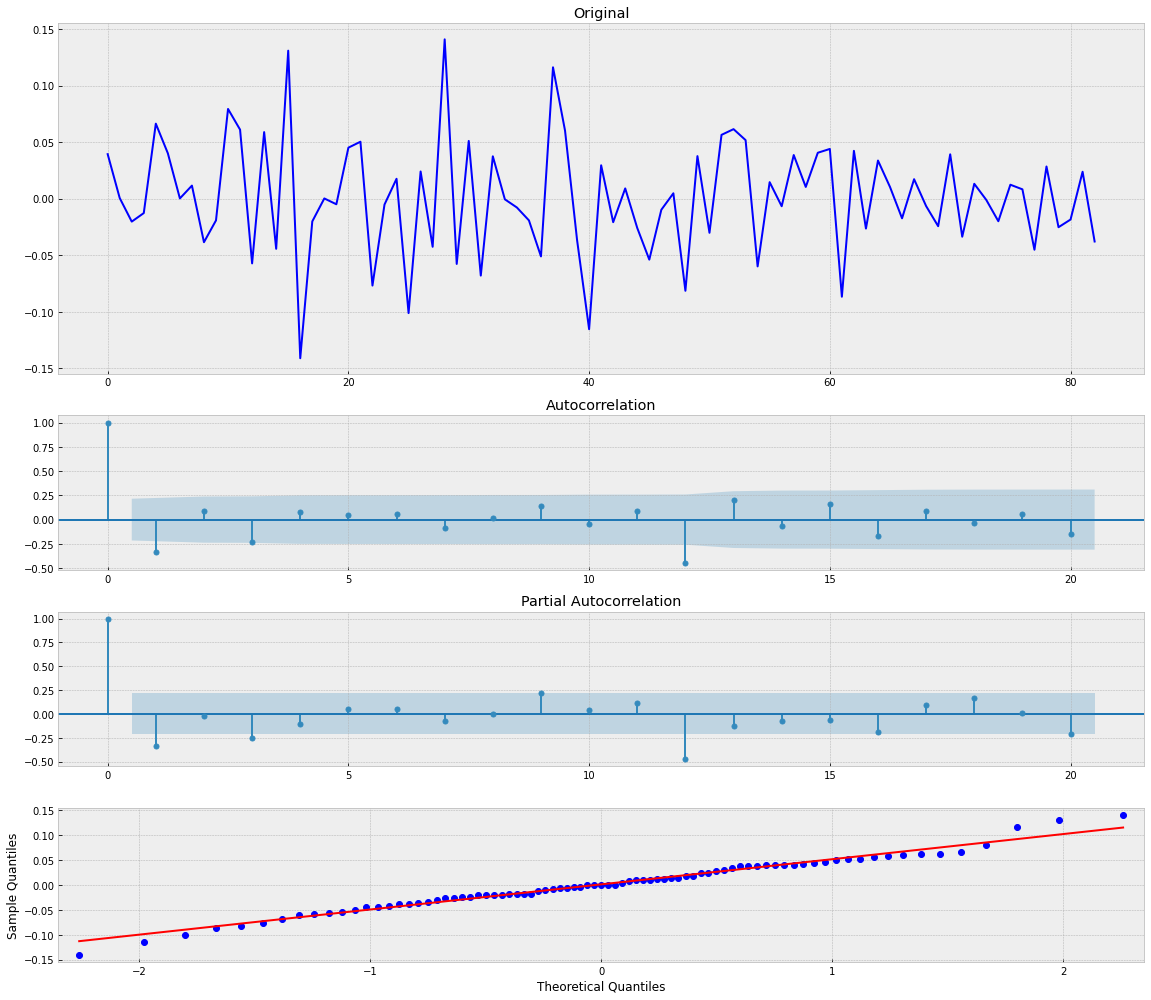

In [245]:
tsplot(res.resid)

In [246]:
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def ts_plot(residuals, stan_residuals, lags=30):
    with plt.style.context('bmh'):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        ax.set_title('GARCH Standardized Residuals KDE')
        residuals.plot(kind='kde', ax=ax)
        plt.show()

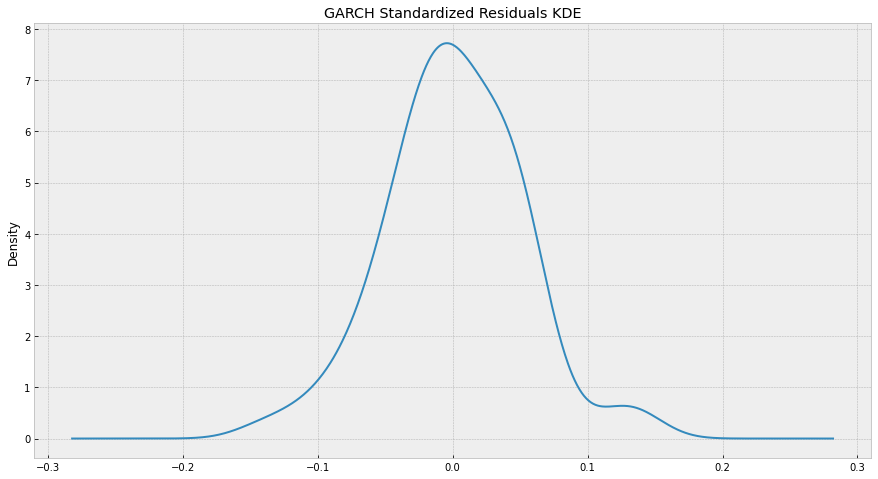

In [249]:
resid = pd.Series(res.resid)
st_resid = pd.Series(np.divide(res.resid, res.conditional_volatility))
ts_plot(resid, st_resid)

**Прогноз**

In [251]:
#horizon=1 сколько значений предсказываем 
forecast = res.forecast(horizon=30)
#предсказание дисперсии 
forecast.residual_variance.iloc[-1]

h.01    0.000900
h.02    0.000970
h.03    0.000939
h.04    0.000985
h.05    0.000972
h.06    0.001003
h.07    0.001000
h.08    0.001022
h.09    0.001025
h.10    0.001043
h.11    0.001048
h.12    0.001063
h.13    0.001070
h.14    0.001083
h.15    0.001091
h.16    0.001102
h.17    0.001110
h.18    0.001120
h.19    0.001129
h.20    0.001139
h.21    0.001147
h.22    0.001156
h.23    0.001164
h.24    0.001173
h.25    0.001181
h.26    0.001189
h.27    0.001197
h.28    0.001204
h.29    0.001212
h.30    0.001219
Name: 82, dtype: float64

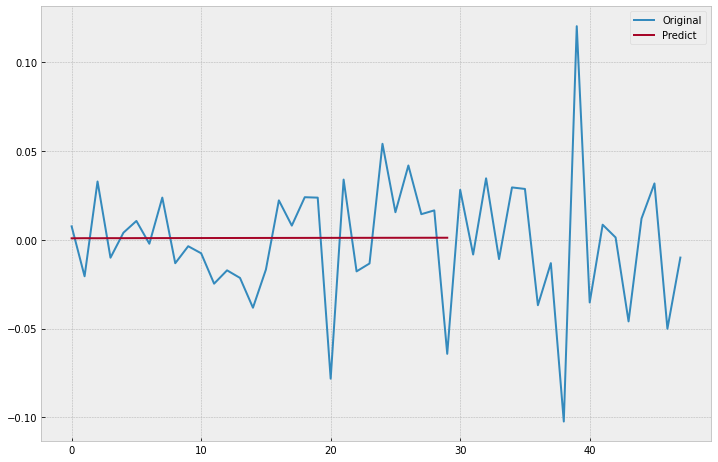

In [265]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 8))
    plt.plot(test_series, label='Original')
    plt.plot(forecast.variance.values[-1, :], label='Predict')
    plt.legend()

График ожидаемой и прогнозируемой дисперсии

### Спрогнозируем дисперсию для фрактального броуновского движения

Результат теста Дики-Фуллера:
Статистический тест               2.685653
p-value                           0.999086
Lags                              5.000000
Number of Observations Used    1435.000000
Критические значения (1%)        -3.434915
Критические значения (5%)        -2.863556
Критические значения (10%)       -2.567843
dtype: float64


есть единичные корни, ряд не стационарен


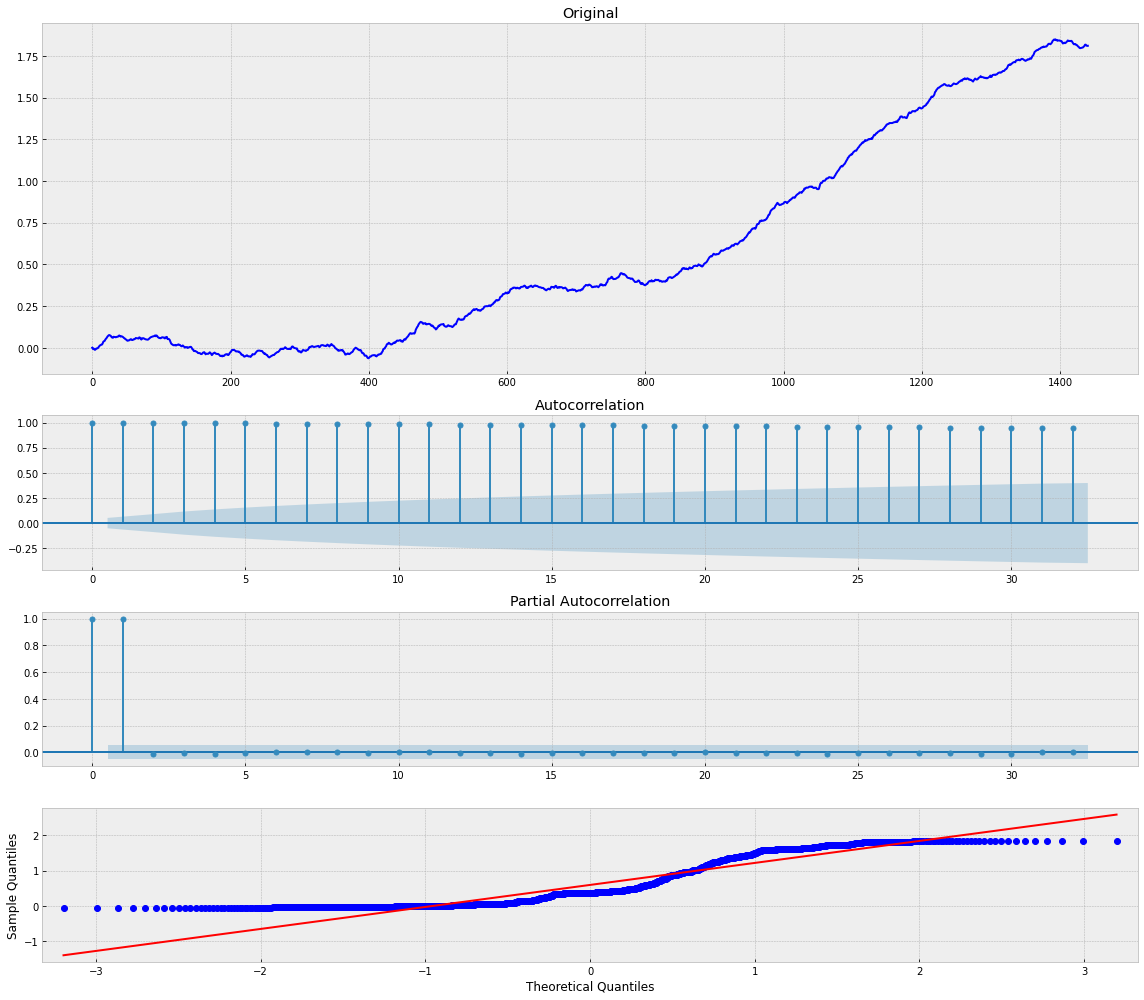

In [276]:
from fbm import FBM
f = FBM(n=1440, hurst=0.75)
fbm = f.fbm()
tsplot(fbm)

Результат теста Дики-Фуллера:
Статистический тест           -7.938218e+00
p-value                        3.368463e-12
Lags                           2.100000e+01
Number of Observations Used    1.172000e+03
Критические значения (1%)     -3.435942e+00
Критические значения (5%)     -2.864009e+00
Критические значения (10%)    -2.568085e+00
dtype: float64


единичных корней нет, ряд стационарен


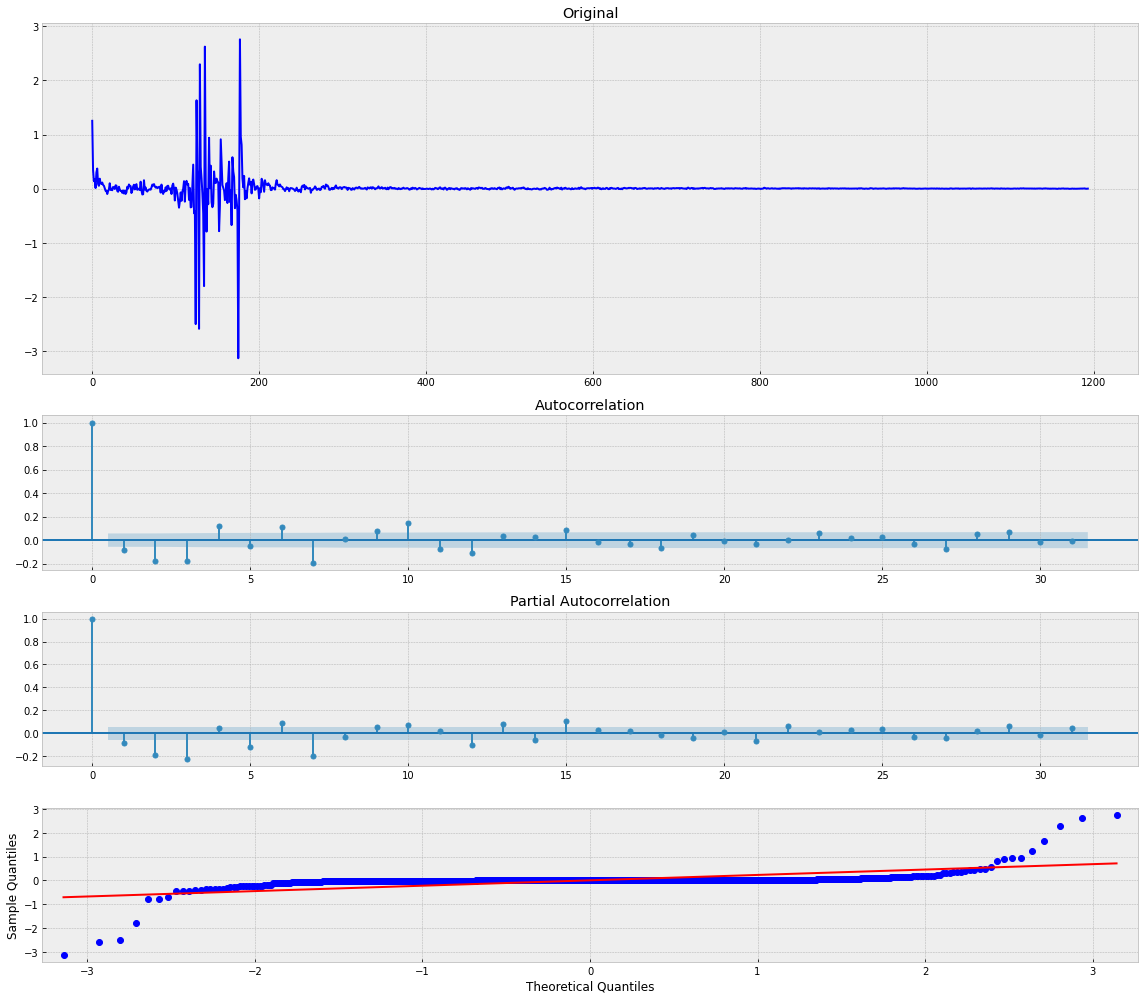

In [287]:
series = boxcox(fbm[fbm > 0], 0)

series = np.diff(series, 1)

train_series, test_series = series[0:len(series)-100], series[len(series)-100:]

tsplot(series)

In [288]:
aic, order, mdl = _get_best_model(train_series)
p_, o_, q_ = order
mdl_6 = smt.ARIMA(train_series, order=(p_,o_,q_)).fit()
mdl_7 = arch_model(train_series, vol='GARCH', p=p_, o=o_, q=q_, dist='StudentsT')
res = mdl_7.fit(update_freq=5, disp='off')

aic: -226.59725 | order: (2, 0, 4)


In [289]:
#horizon=1 сколько значений предсказываем 
forecast = res.forecast(horizon=100)
#предсказание дисперсии 
forecast.residual_variance.iloc[-1]

h.001    0.000799
h.002    0.000847
h.003    0.001228
h.004    0.001290
h.005    0.001598
           ...   
h.096    0.006368
h.097    0.006374
h.098    0.006379
h.099    0.006385
h.100    0.006390
Name: 1093, Length: 100, dtype: float64

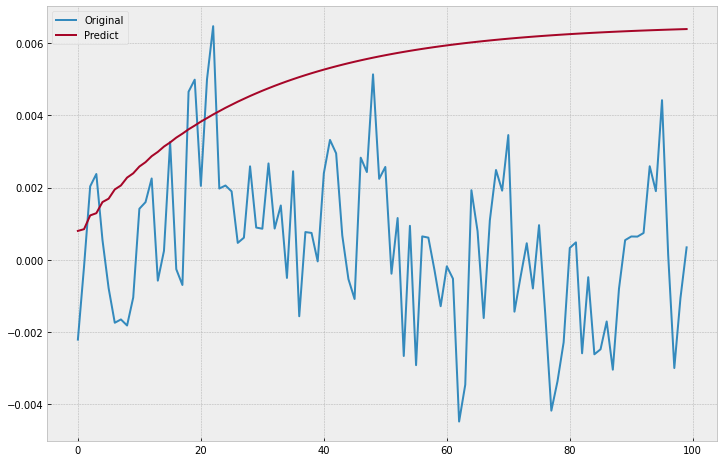

In [290]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 8))
    plt.plot(test_series, label='Original')
    plt.plot(forecast.variance.values[-1, :], label='Predict')
    plt.legend()

График ожидаемой и прогнозируемой дисперсии